Use cellchat and LIANA analysis the organ specifc cell-cell communication.

In [ ]:
import sys,warnings
sys.path.append('/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/') # change to the path where devendo.py stript located.
import devendo as de
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata, re,os
import scanpy.external as sce
from scipy.sparse import csr_matrix,csc_matrix, find
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import liana as li
import decoupler as dc
import omnipath as op
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load data

In [6]:
# STED-EC dataset
adata = sc.read_h5ad('DATA/sted-ec.h5ad')

In [7]:
used_columns = ['embryonic_period','gender','n_counts','n_genes','mouse_part_summary','new_cellid_unique','organ','celltype']

Organ specific cells of epithelial cells, endothelial cells, and mesenchymal cells.

In [195]:
data = {}
for organ in ['Lung','Brain','Kidney','Liver']:
    data[organ] = sc.read('DATA/niche/%s_niche.h5ad'%x)

## 2. CellChat analysis

In [7]:
bdata = anndata.concat([data[x] for x in data])

In [12]:
lr_cellchat = de.cellchat(bdata, cells_per_group = 2000,
                       species = 'mouse',
                       groupby = 'celltype', 
                       condition = 'organ')

Run cellchat for Lung

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Endothelial cells Epithelial cells Mesenchymal cells 
Issue identified!! Please check the official Gene Symbol of the following genes:  
 H2-BI H2-Ea-ps 
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 3 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                            

In [758]:
lr_cellchat = lr_cellchat[lr_cellchat['source']!='Prithelial cell']
lr_cellchat = lr_cellchat[lr_cellchat['target']!='Prithelial cell']

In [759]:
lr_cellchat.to_excel('cellchat/organ_cellchat.xlsx', index=False, sheet_name='cellchat')
# lr_cellchat = pd.ExcelFile('cellchat/organ_cellchat.xlsx').parse('cellchat')

In [42]:
for organ in ['Lung','Brain','Kidney','Liver']:
    res = de.plot_interaction(lr=lr_cellchat[lr_cellchat['condition'] == organ], groupby='celltype',adata=data[organ],filename = 'figures/R1Q17_%s_interaction.pdf'%organ)

Saving 7 x 7 in image
Save file <figures/R1Q17_Lung_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Brain_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Kidney_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Liver_interaction.pdf>


### 2.1 Endothelial cells -> epithelial cells

In [484]:
sub_dlr = lr_cellchat[lr_cellchat['prob'] > 0.001]
sub_dlr = sub_dlr[(sub_dlr['source'] == 'Endothelial cells')&(sub_dlr['target'] == 'Epithelial cells')]
sub_dlr = sub_dlr[sub_dlr['annotation'].isin(['Cell-Cell Contact',  'Secreted Signaling'])] # 'ECM-Receptor'
counts = sub_dlr['interaction_name'].value_counts()
sub_dlr = sub_dlr[sub_dlr['interaction_name'].isin(counts[counts<=2].index.values)]

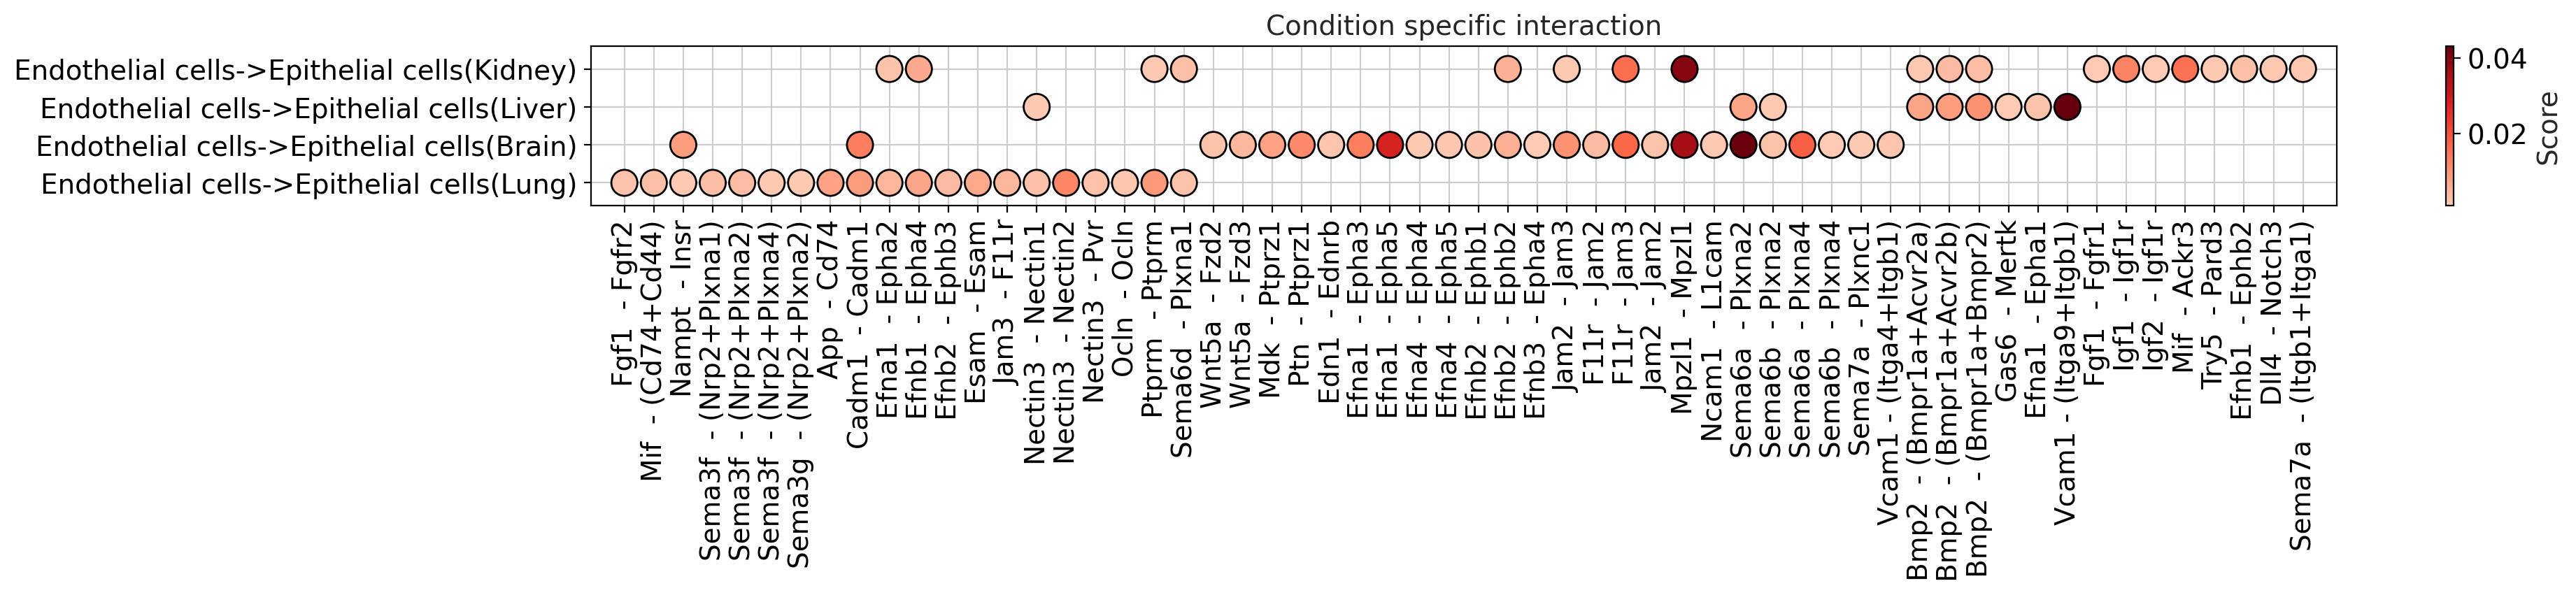

<Figure size 400x400 with 0 Axes>

In [488]:
de.plot_lr(sub_dlr, swap_axis=False, x_margin = 0.02, y_margin = 0.2, figsize = (20,1.5))
plt.show()

### 2.2 Endothelial cells -> mesenchymal cells

In [489]:
sub_dlr = lr_cellchat[lr_cellchat['prob'] > 0.001]
sub_dlr = sub_dlr[(sub_dlr['source'] == 'Endothelial cells')&(sub_dlr['target'] == 'Mesenchymal cells')]
sub_dlr = sub_dlr[sub_dlr['annotation'].isin(['Cell-Cell Contact',  'Secreted Signaling'])] # 'ECM-Receptor'
counts = sub_dlr['interaction_name'].value_counts()
sub_dlr = sub_dlr[sub_dlr['interaction_name'].isin(counts[counts<=2].index.values)]

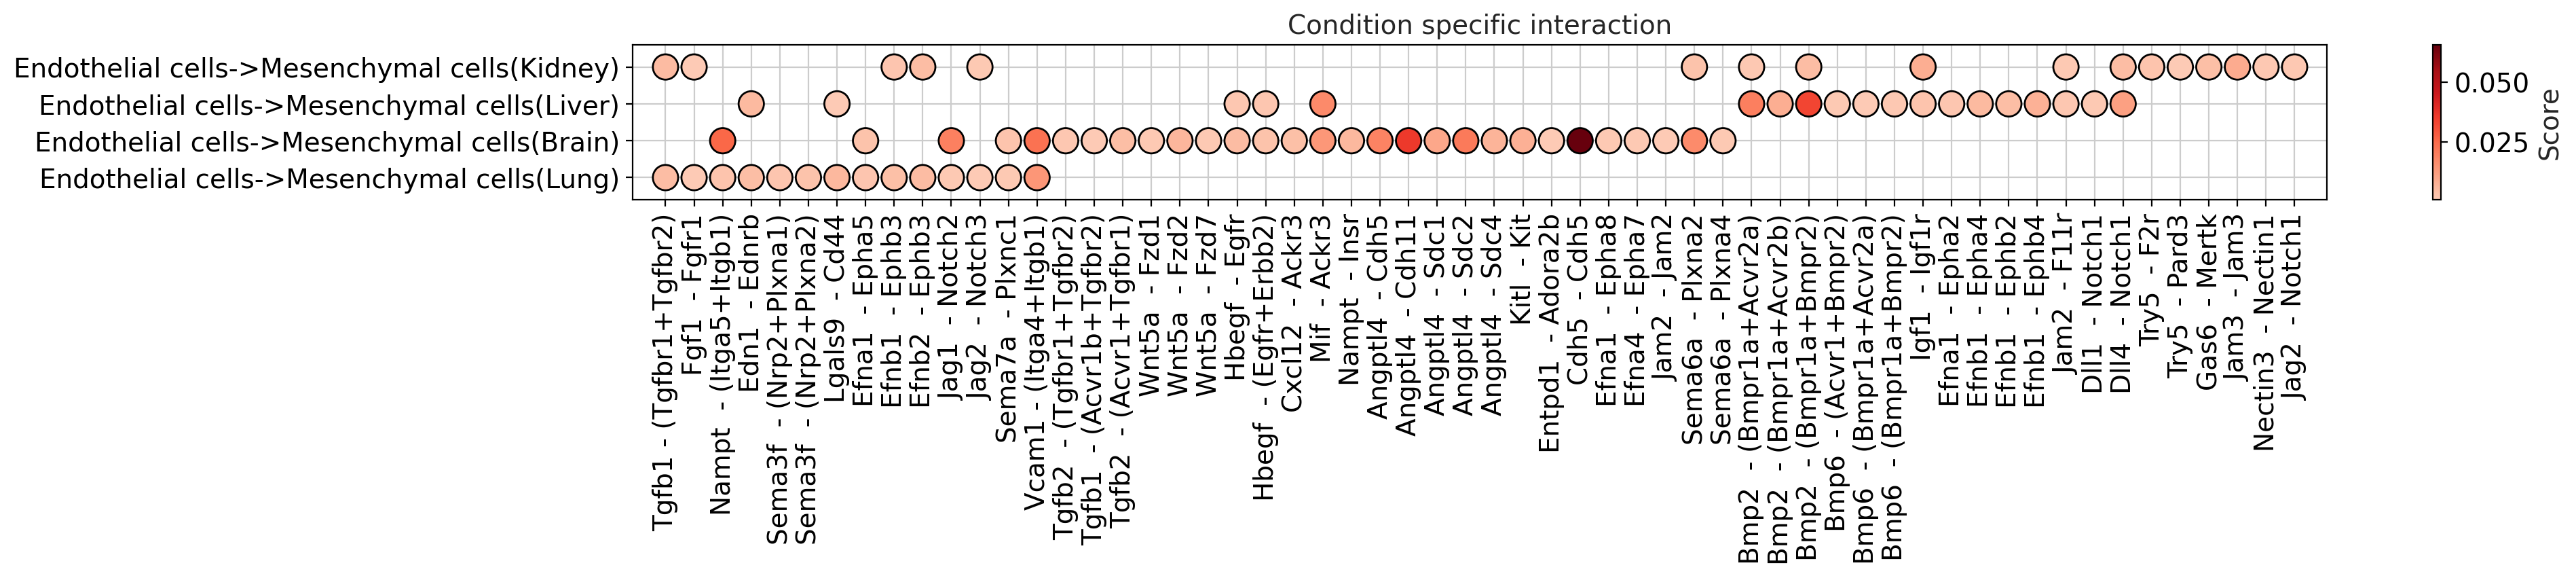

<Figure size 400x400 with 0 Axes>

In [490]:
de.plot_lr(sub_dlr, swap_axis=False, x_margin = 0.02, y_margin = 0.2, figsize = (20,1.5))
plt.show()

## 2. LIANA analysis

In [517]:
interaction1 = de.get_cellchat_interaction()
interaction = de.split(interaction1['ligand'],interaction1['annotation'])
pathway = de.split(interaction1['ligand'],interaction1['pathway_name'])

In [286]:
resource = li.rs.select_resource('consensus')
map_df = li.rs.get_hcop_orthologs(url='https://ftp.ebi.ac.uk/pub/databases/genenames/hcop/human_mouse_hcop_fifteen_column.txt.gz',
                                  columns=['human_symbol', 'mouse_symbol'],
                                   # NOTE: HCOP integrates multiple resource, so we can filter out mappings in at least 3 of them for confidence
                                   min_evidence=3
                                   )
# rename the columns to source and target, respectively for the original organism and the target organism
map_df = map_df.rename(columns={'human_symbol':'source', 'mouse_symbol':'target'})

# We will then translate
mouse = li.rs.translate_resource(resource,
                                 map_df=map_df,
                                 columns=['ligand', 'receptor'],
                                 replace=True,
                                 # Here, we will be harsher and only keep mappings that don't map to more than 1 mouse gene
                                 one_to_many=1
                                 )

In [350]:
# li.mt.rank_aggregate(ldata,
#                      groupby='celltype',
#                      resource_name='consensus',
#                      resource = mouse,
#                      use_raw = False,
#                      expr_prop=0.1,
#                      verbose=True)

Using `.X`!
23679 features of mat are empty, they will be removed.


Using provided `resource`.


0.05 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6000 samples and 1516 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:20<00:00, 49.80it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [638]:
ldata = []
for x in data:
    print(x)
    sub_adata = de.choiceGroupCells(data[x], 'celltype', 2000)
    methods = [cellchat]
    new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)
    new_rank_aggregate(adata= sub_adata, use_raw = False, groupby='celltype', resource = mouse)
    res = sub_adata.uns['liana_res']
    res.rename(columns = {'ligand_complex':'ligand','receptor_complex':'receptor','lr_probs':'prob','cellchat_pvals':'pval'},inplace = True)
    res['interaction_name_2'] = res['ligand'] + ' - '+res['receptor']
    res['condition'] = x
    annotation = np.array(['Others']*res.shape[0],dtype = '<U20')
    for i in interaction:
        annotation[res['ligand'].isin([interaction[i]])] = i
    res['annotation'] = annotation
    ldata.append(res)
lr_liana = pd.concat(ldata)

Lung
Brain
Kidney
Liver


In [643]:
lr_liana.loc[lr_liana['ligand'].isin(interaction['Cell-Cell Contact']),'annotation'] = 'Cell-Cell Contact'
lr_liana.loc[lr_liana['ligand'].isin(interaction['ECM-Receptor']),'annotation'] = 'ECM-Receptor'
lr_liana.loc[lr_liana['ligand'].isin(interaction['Secreted Signaling']),'annotation'] = 'Secreted Signaling'

lr_liana['pathway_name'] = 'Others'
for i in pathway:
    lr_liana.loc[lr_liana['ligand'].isin(pathway[i]),'pathway_name'] = i

In [760]:
lr_liana = lr_liana[lr_liana['source']!='Prithelial cell']
lr_liana = lr_liana[lr_liana['target']!='Prithelial cell']

In [761]:
lr_liana.reset_index(inplace = True,drop = True)

In [762]:
lr_liana.to_excel('cellchat/organ_liana.xlsx', index=False, sheet_name='liana')

## 3. Merge cellchat and Liana results

In [646]:
lr_liana['database'] = 'liana'
lr_cellchat['database'] = 'cellchat'

In [647]:
sub_lr_liana = lr_liana[~lr_liana['ligand'].isin(lr_cellchat['ligand'])]
sub_lr_liana = sub_lr_liana[sub_lr_liana['magnitude_rank'] <0.1]

In [648]:
lr = pd.concat([lr_cellchat, sub_lr_liana])

### 3.1 Endothelial cells -> epithelial cells

In [764]:
# 顺序不可以变
sub_dlr = lr[lr['prob'] > 0.001]
sub_dlr = sub_dlr[(sub_dlr['source'] == 'Endothelial cells')&(sub_dlr['target'] == 'Epithelial cells')]
counts = sub_dlr['interaction_name_2'].value_counts()
sub_dlr = sub_dlr[sub_dlr['interaction_name_2'].isin(counts[counts<=1].index.values)]
# sub_dlr = sub_dlr[~sub_dlr['annotation'].isin(['ECM-Receptor'])] # 'ECM-Receptor'
sub_dlr = sub_dlr[sub_dlr['pval'] == 0.0]
sub_dlr['group'] = sub_dlr['ligand'] + ' - ' + sub_dlr['condition']
sub_dlr = sub_dlr.loc[sub_dlr.groupby('group')['prob'].idxmax()]
# sub_dlr = sub_dlr[~sub_dlr.apply(lambda x: x.astype(str).str.contains('Col')).any(axis=1)]
sub_dlr['condition'] = pd.Categorical(np.array(sub_dlr['condition']), ['Brain','Lung','Liver','Kidney'])

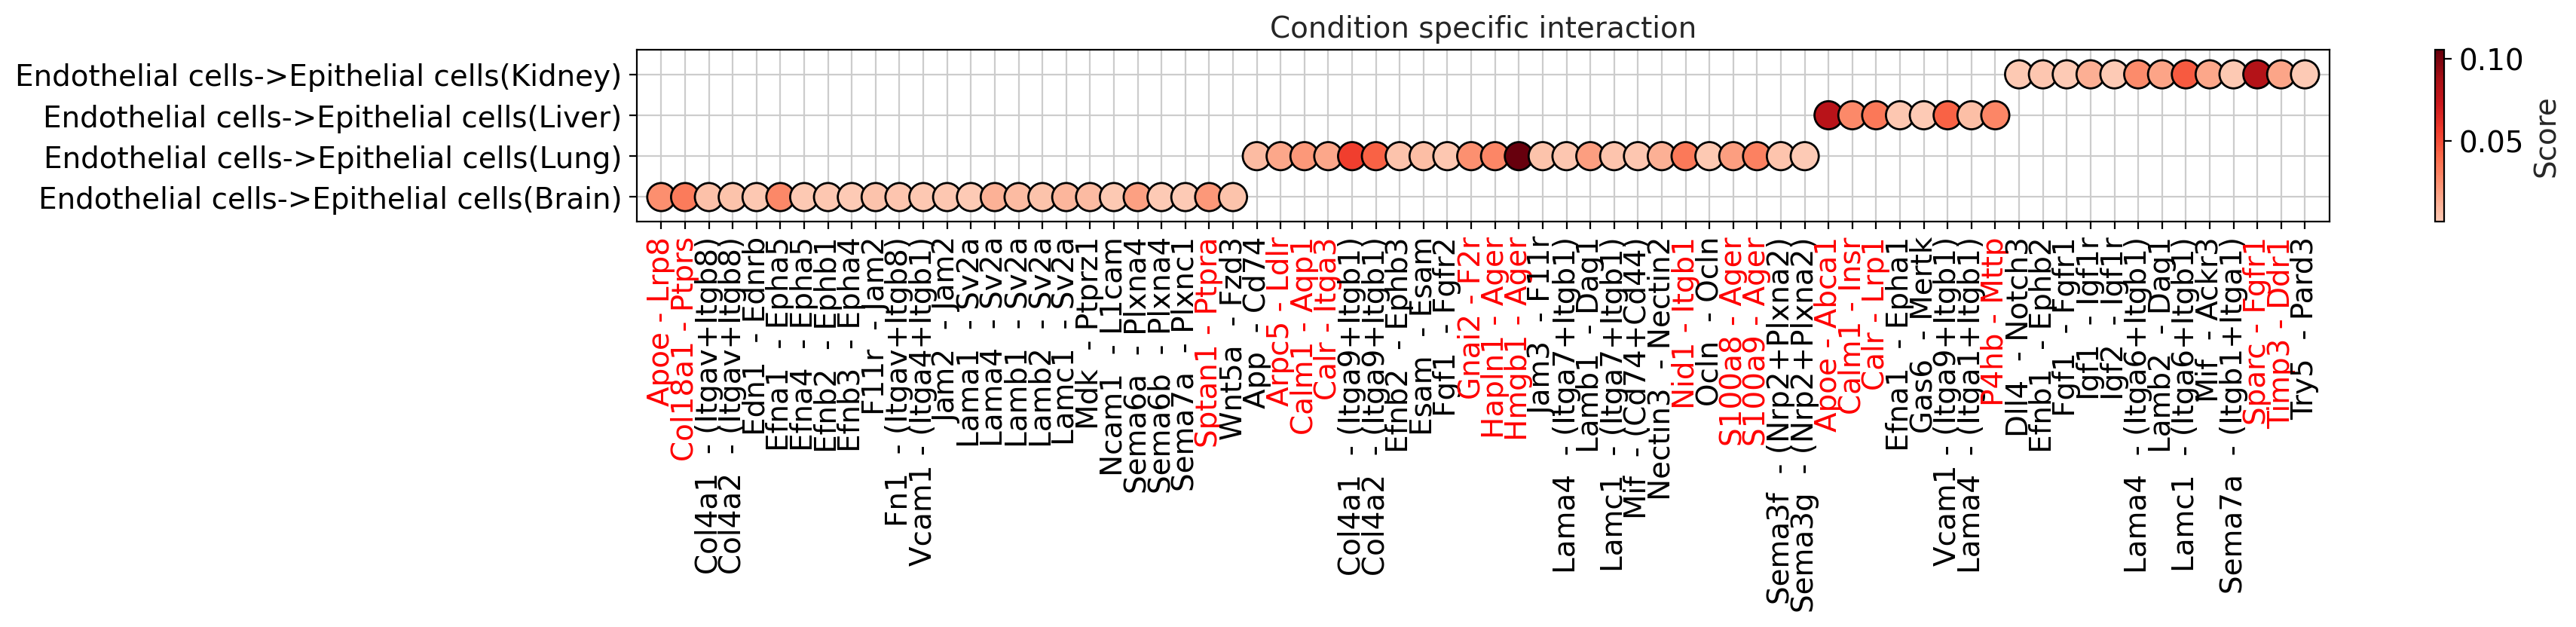

In [767]:
xtick_colors = {'database':{'cellchat': '#000000', 'liana': 'red'}}
de.plot_lr(sub_dlr, swap_axis=False, x_margin = 0.015, y_margin = 0.2, xtick_colors=xtick_colors, figsize = (18,1.5))
plt.show()
# plt.savefig('figures/R1Q17_cellchat_plus_liana_organ_ec2epi_with_ECM.pdf')

### 3.2 Endothelial cells -> mesenchymal cells

In [720]:
sub_dlr = lr[lr['prob'] > 0.001]
sub_dlr = sub_dlr[(sub_dlr['source'] == 'Endothelial cells')&(sub_dlr['target'] == 'Mesenchymal cells')]
counts = sub_dlr['interaction_name_2'].value_counts()
sub_dlr = sub_dlr[sub_dlr['interaction_name_2'].isin(counts[counts<=1].index.values)]
# sub_dlr = sub_dlr[~sub_dlr['annotation'].isin(['ECM-Receptor'])] # 'ECM-Receptor'
sub_dlr = sub_dlr[sub_dlr['pval'] == 0.0]
sub_dlr['group'] = sub_dlr['ligand'] + ' - ' + sub_dlr['condition']
sub_dlr = sub_dlr.loc[sub_dlr.groupby('group')['prob'].idxmax()]
# sub_dlr = sub_dlr[~sub_dlr.apply(lambda x: x.astype(str).str.contains('Col')).any(axis=1)]
sub_dlr['condition'] = pd.Categorical(np.array(sub_dlr['condition']), ['Brain','Lung','Liver','Kidney'])

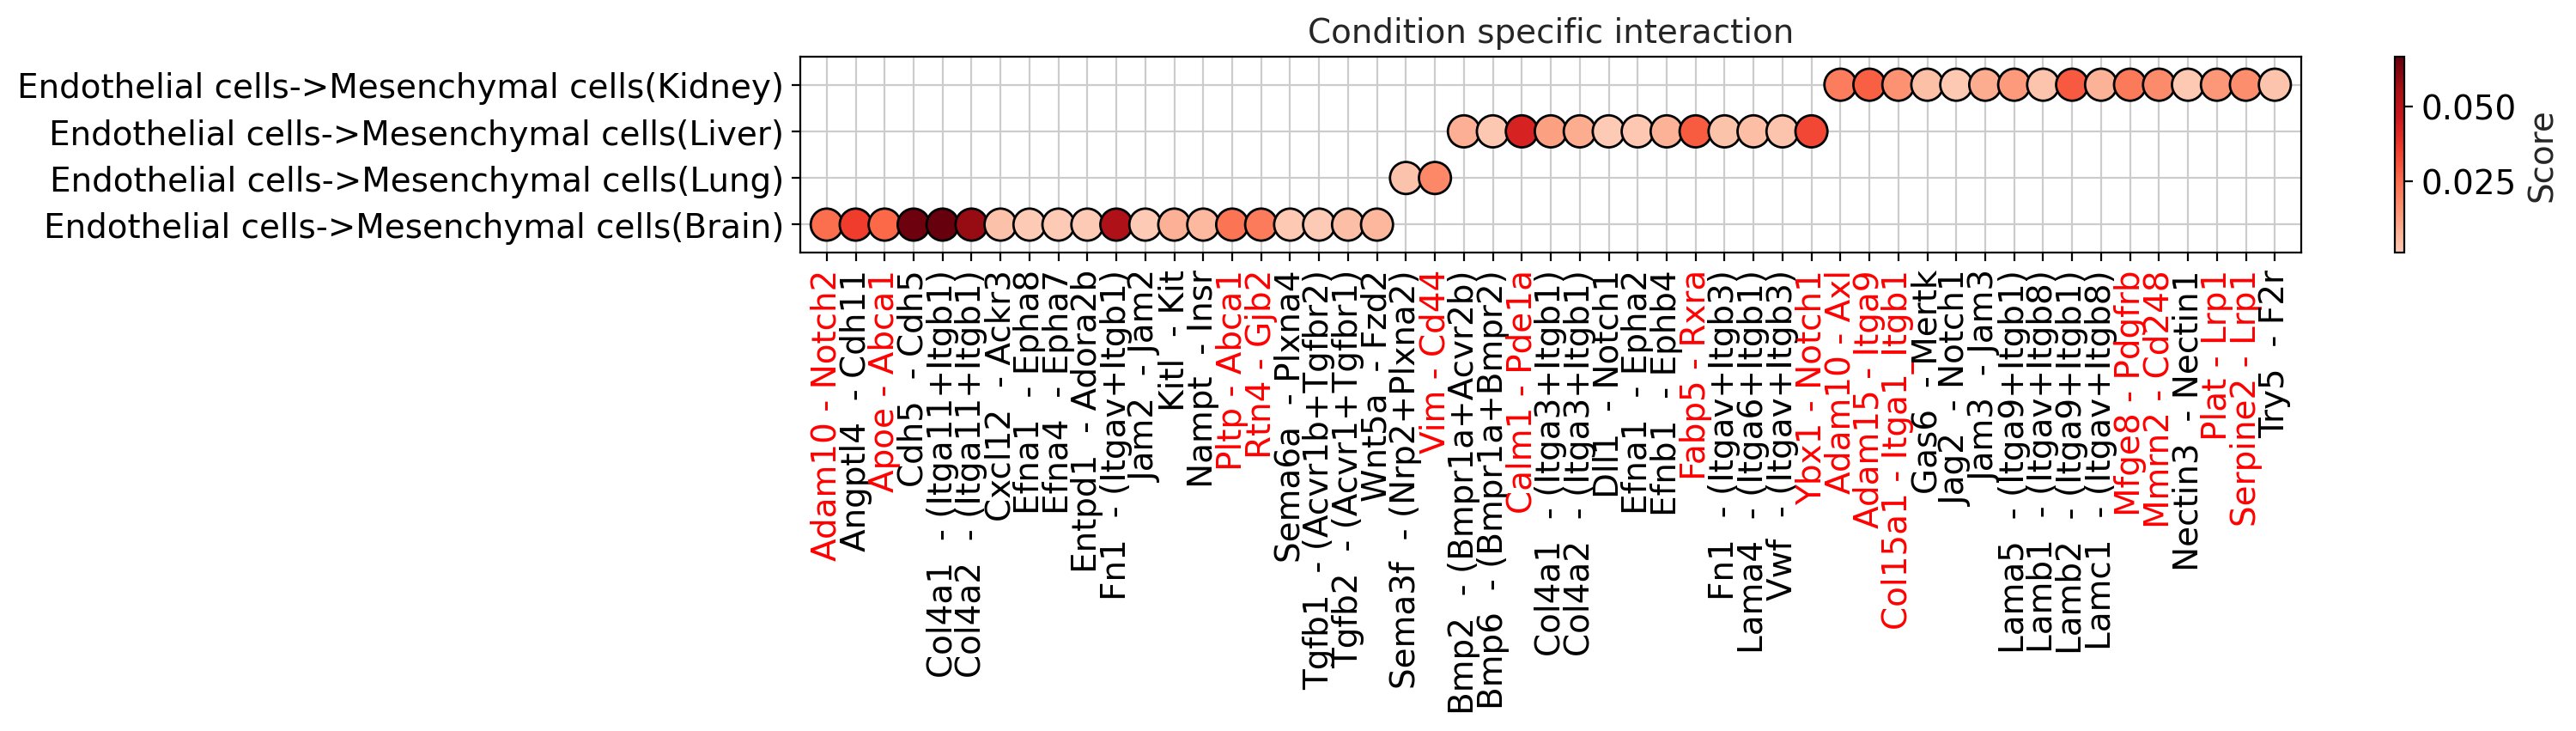

In [723]:
xtick_colors = {'database':{'cellchat': '#000000', 'liana': 'red'}}
de.plot_lr(sub_dlr, swap_axis=False, x_margin = 0.018, y_margin = 0.2, xtick_colors=xtick_colors, figsize = (14,1.5))
plt.show()
# plt.savefig('figures/R1Q17_cellchat_plus_liana_organ_ec2mes_with_ECM.pdf')

### 3.3 River plot

In [ ]:
lr = lr[lr['pval'] == 0]

In [749]:
bdata = bdata[bdata.obs['celltype'].isin(['Endothelial cells', 'Epithelial cells', 'Mesenchymal cells'])]

In [753]:
np.unique(bdata.obs['celltype'])

array(['Endothelial cells', 'Epithelial cells', 'Mesenchymal cells'],
      dtype=object)

In [751]:
bdata.obs['celltype'] = pd.Categorical(np.array(bdata.obs['celltype']),['Endothelial cells','Epithelial cells','Mesenchymal cells'])
bdata.uns['celltype_colors'] = de.bestcolors(3,'low')

In [757]:
for organ in np.unique(lr['condition']):
    sub_lr = lr[lr['condition'] == organ]
    sub_lr = sub_lr[sub_lr['source']!=sub_lr['target']]
    sub_lr = sub_lr[sub_lr['source']!='Prithelial cell']
    sub_lr = sub_lr[sub_lr['target']!='Prithelial cell']
    de.plot_interaction(lr=sub_lr, groupby='celltype',adata=bdata, filename = 'figures/R1Q17_%s_interaction.pdf'%organ) # 

Saving 7 x 7 in image
Save file <figures/R1Q17_Brain_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Kidney_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Liver_interaction.pdf>
Saving 7 x 7 in image
Save file <figures/R1Q17_Lung_interaction.pdf>
